In [ ]:
import datetime
import math
import numpy as np
import torch
from torch import nn
from torch.nn import Module, Parameter
import torch.nn.functional as F


class GNN(Module):
    def __init__(self, hidden_size, step=1):
        super(GNN, self).__init__()
        self.step = step
        self.hidden_size = hidden_size
        self.input_size = hidden_size * 2
        self.gate_size = 3 * hidden_size
        self.w_ih = Parameter(torch.Tensor(self.gate_size, self.input_size))
        self.w_hh = Parameter(torch.Tensor(self.gate_size, self.hidden_size))
        self.b_ih = Parameter(torch.Tensor(self.gate_size))
        self.b_hh = Parameter(torch.Tensor(self.gate_size))
        self.b_iah = Parameter(torch.Tensor(self.hidden_size))
        self.b_oah = Parameter(torch.Tensor(self.hidden_size))

        self.linear_edge_in = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.linear_edge_out = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.linear_edge_f = nn.Linear(self.hidden_size, self.hidden_size, bias=True)

    def GNNCell(self, A, hidden):
        input_in = torch.matmul(A[:, :, :A.shape[1]], self.linear_edge_in(hidden)) + self.b_iah
        input_out = torch.matmul(A[:, :, A.shape[1]: 2 * A.shape[1]], self.linear_edge_out(hidden)) + self.b_oah
        inputs = torch.cat([input_in, input_out], 2)
        gi = F.linear(inputs, self.w_ih, self.b_ih)
        gh = F.linear(hidden, self.w_hh, self.b_hh)
        i_r, i_i, i_n = gi.chunk(3, 2)
        h_r, h_i, h_n = gh.chunk(3, 2)
        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + resetgate * h_n)
        hy = newgate + inputgate * (hidden - newgate)
        return hy

    def forward(self, A, hidden):
        for i in range(self.step):
            hidden = self.GNNCell(A, hidden)
        return hidden


class SessionGraph(Module):
    def __init__(self, opt, n_node, n_side):
        super(SessionGraph, self).__init__()
        self.hidden_size = opt.hiddenSize
        self.n_node = n_node
        self.n_side = n_side
        self.batch_size = opt.batchSize
        self.nonhybrid = opt.nonhybrid
        print(self.n_node)
        print(self.n_side)
        self.embedding = nn.Embedding(self.n_node, self.hidden_size)
        self.gnn = GNN(self.hidden_size, step=opt.step)
        self.embedding_side = nn.Embedding(self.n_side, self.hidden_size)
        self.gnn_side = GNN(self.hidden_size, step=opt.step)
        self.linear_one = nn.Linear(self.hidden_size * 2, self.hidden_size * 2, bias=True)
        self.linear_two = nn.Linear(self.hidden_size * 2, self.hidden_size * 2, bias=True)
        self.linear_three = nn.Linear(self.hidden_size * 2, 1, bias=False)
        self.linear_transform = nn.Linear(self.hidden_size * 4, self.hidden_size * 2, bias=True)
        self.loss_function = nn.CrossEntropyLoss()
        self.attention_loss = nn.KLDivLoss(reduction="batchmean")
        self.optimizer = torch.optim.Adam(self.parameters(), lr=opt.lr, weight_decay=opt.l2)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=opt.lr_dc_step, gamma=opt.lr_dc)
        self.softmax = nn.Softmax(dim=1)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def compute_scores(self, hidden, mask):
        ht = hidden[torch.arange(mask.shape[0]).long(), torch.sum(mask, 1) - 1]  # batch_size x latent_size
        q1 = self.linear_one(ht).view(ht.shape[0], 1, ht.shape[1])  # batch_size x 1 x latent_size
        q2 = self.linear_two(hidden)  # batch_size x seq_length x latent_size
        alpha = self.linear_three(torch.tanh(q1 + q2))
        alpha = alpha.masked_fill((1.0 - mask.view(mask.shape[0], -1, 1).float()).bool(), float('-inf'))
        alpha = self.softmax(alpha) * mask.view(mask.shape[0], -1, 1).float()
        a = torch.sum(alpha * hidden, 1)
        #a = torch.sum(alpha * hidden * mask.view(mask.shape[0], -1, 1).float(), 1)
        if not self.nonhybrid:
            a = self.linear_transform(torch.cat([a, ht], 1))
        b = self.embedding.weight[1:]  # n_nodes x latent_size
        cat_b = self.embedding_side.weight[index_list]
        b = torch.cat((b, cat_b), 1)
        scores = torch.matmul(a, b.transpose(1, 0))
        return scores, alpha[:, :, 0]

    def forward(self, inputs, A, side_info, B):
        hidden = self.embedding(inputs)
        hidden = self.gnn(A, hidden)
        hidden_side = self.embedding(side_info)
        hidden_side = self.gnn(B, hidden_side)

        return hidden, hidden_side


def trans_to_cuda(variable):
    if torch.cuda.is_available():
        return variable.cuda()
    else:
        return variable


def trans_to_cpu(variable):
    if torch.cuda.is_available():
        return variable.cpu()
    else:
        return variable


def forward(model, i, data):
    alias_inputs, alias_side, A, items, B, side_info, mask, targets, attention_item_target = data.get_slice(i)
    attention_item_target = trans_to_cuda(torch.Tensor(attention_item_target).float())
    alias_inputs = trans_to_cuda(torch.Tensor(alias_inputs).long())
    alias_side = trans_to_cuda(torch.Tensor(alias_side).long())
    items = trans_to_cuda(torch.Tensor(items).long())
    side_info = trans_to_cuda(torch.Tensor(side_info).long())
    A = trans_to_cuda(torch.Tensor(A).float())
    B = trans_to_cuda(torch.Tensor(B).float())
    mask = trans_to_cuda(torch.Tensor(mask).long())
    hidden, hidden_side = model(items, A, side_info, B)
    get = lambda i: hidden[i][alias_inputs[i]]
    seq_hidden = torch.stack([get(i) for i in torch.arange(len(alias_inputs)).long()])
    get = lambda i: hidden_side[i][alias_side[i]]
    seq_side = torch.stack([get(i) for i in torch.arange(len(alias_side)).long()])
    seq = torch.cat((seq_hidden, seq_side), 2)
    scores, attention = model.compute_scores(seq, mask)
    return targets, scores, attention, attention_item_target


def train_test(model, train_data, test_data, attention_lambda):
    print('start training: ', datetime.datetime.now())
    epsilon = 1e-7
    model.train()
    total_loss = 0.0
    slices = train_data.generate_batch(model.batch_size)
    for i, j in zip(slices, np.arange(len(slices))):
        model.optimizer.zero_grad()
        targets, scores, attention, attention_item_target = forward(model, i, train_data)
        targets = trans_to_cuda(torch.Tensor(targets).long())
        attention_loss = model.attention_loss((attention + epsilon).log(), (attention_item_target + epsilon))
        loss = model.loss_function(scores, targets - 1) + attention_lambda * attention_loss
        loss.backward()
        model.optimizer.step()
        total_loss += loss
        if j % int(len(slices) / 5 + 1) == 0:
            print('[%d/%d] Loss: %.4f' % (j, len(slices), loss.item()))
    model.scheduler.step()
    print('\tLoss:\t%.3f' % total_loss)

    print('start predicting: ', datetime.datetime.now())
    model.eval()
    hit, mrr = [], []
    slices = test_data.generate_batch(model.batch_size)
    for i in slices:
        targets, scores, _, _, = forward(model, i, test_data)
        sub_scores = scores.topk(20)[1]
        sub_scores = trans_to_cpu(sub_scores).detach().numpy()
        for score, target, mask in zip(sub_scores, targets, test_data.mask):
            hit.append(np.isin(target - 1, score))
            if len(np.where(score == target - 1)[0]) == 0:
                mrr.append(0)
            else:
                mrr.append(1 / (np.where(score == target - 1)[0][0] + 1))
    hit = np.mean(hit) * 100
    mrr = np.mean(mrr) * 100
    return hit, mrr

In [ ]:
import networkx as nx
import numpy as np


def build_graph(train_data):
    graph = nx.DiGraph()
    for seq in train_data:
        for i in range(len(seq) - 1):
            if graph.get_edge_data(seq[i], seq[i + 1]) is None:
                weight = 1
            else:
                weight = graph.get_edge_data(seq[i], seq[i + 1])['weight'] + 1
            graph.add_edge(seq[i], seq[i + 1], weight=weight)
    for node in graph.nodes:
        sum = 0
        for j, i in graph.in_edges(node):
            sum += graph.get_edge_data(j, i)['weight']
        if sum != 0:
            for j, i in graph.in_edges(i):
                graph.add_edge(j, i, weight=graph.get_edge_data(j, i)['weight'] / sum)
    return graph


def data_masks(all_usr_pois, side_info, item_tail):
    us_lens = [len(upois) for upois in all_usr_pois]
    len_max = max(us_lens)
    us_pois = [upois + item_tail * (len_max - le) for upois, le in zip(all_usr_pois, us_lens)]
    us_msks = [[1] * le + [0] * (len_max - le) for le in us_lens]
    us_side = [upois + item_tail * (len_max - le) for upois, le in zip(side_info, us_lens)]
    return us_pois, us_side, us_msks, len_max


def split_validation(train_set, valid_portion):
    train_set_x, train_set_y = train_set
    n_samples = len(train_set_x)
    sidx = np.arange(n_samples, dtype='int32')
    np.random.shuffle(sidx)
    n_train = int(np.round(n_samples * (1. - valid_portion)))
    valid_set_x = [train_set_x[s] for s in sidx[n_train:]]
    valid_set_y = [train_set_y[s] for s in sidx[n_train:]]
    train_set_x = [train_set_x[s] for s in sidx[:n_train]]
    train_set_y = [train_set_y[s] for s in sidx[:n_train]]

    return (train_set_x, train_set_y), (valid_set_x, valid_set_y)


class Data():
    def __init__(self, data, side_info, shuffle=False, graph=None):
        inputs = data[0]
        inputs, side, mask, len_max = data_masks(inputs, side_info, [0])
        self.inputs = np.asarray(inputs)
        self.side = np.asarray(side)
        self.mask = np.asarray(mask)
        self.len_max = len_max
        self.targets = np.asarray(data[1])
        self.length = len(inputs)
        self.shuffle = shuffle
        self.graph = graph

    def generate_batch(self, batch_size):
        if self.shuffle:
            shuffled_arg = np.arange(self.length)
            np.random.shuffle(shuffled_arg)
            self.inputs = self.inputs[shuffled_arg]
            self.mask = self.mask[shuffled_arg]
            self.side = self.side[shuffled_arg]
            self.targets = self.targets[shuffled_arg]
        n_batch = int(self.length / batch_size)
        if self.length % batch_size != 0:
            n_batch += 1
        slices = np.split(np.arange(n_batch * batch_size), n_batch)
        slices[-1] = slices[-1][:(self.length - batch_size * (n_batch - 1))]
        return slices

    def get_slice(self, i):
        attention_weight = 1.0
        inputs, side, mask, targets = self.inputs[i], self.side[i], self.mask[i], self.targets[i]
        items, n_node, A, alias_inputs = [], [], [], []

        #mask_sum = np.expand_dims(np.sum(mask, axis=1), axis=-1)
        #default_attention_item = mask / mask_sum
        default_attention_item = mask * 1e-6
        default_attention_item[np.where(inputs == np.expand_dims(targets, axis=-1))] += attention_weight
        default_attention_item_sum = np.expand_dims(np.sum(default_attention_item, axis=1), axis=-1)
        default_attention_item = default_attention_item / default_attention_item_sum

        #default_attention_side = mask / mask_sum
        default_attention_side = mask * 1e-6
        default_attention_side[np.where(side == np.expand_dims(index_list[(targets - 1)], axis=-1))] += attention_weight
        default_attention_side_sum = np.expand_dims(np.sum(default_attention_side, axis=1), axis=-1)
        default_attention_side = default_attention_side / default_attention_side_sum


        for u_input in inputs:
            n_node.append(len(np.unique(u_input)))
        max_n_node = np.max(n_node)
        for u_input in inputs:
            node = np.unique(u_input)
            items.append(node.tolist() + (max_n_node - len(node)) * [0])
            u_A = np.zeros((max_n_node, max_n_node))
            for i in np.arange(len(u_input) - 1):
                if u_input[i + 1] == 0:
                    break
                u = np.where(node == u_input[i])[0][0]
                v = np.where(node == u_input[i + 1])[0][0]
                u_A[u][v] = 1
            u_sum_in = np.sum(u_A, 0)
            u_sum_in[np.where(u_sum_in == 0)] = 1
            u_A_in = np.divide(u_A, u_sum_in)
            u_sum_out = np.sum(u_A, 1)
            u_sum_out[np.where(u_sum_out == 0)] = 1
            u_A_out = np.divide(u_A.transpose(), u_sum_out)
            u_A = np.concatenate([u_A_in, u_A_out]).transpose()
            A.append(u_A)
            alias_inputs.append([np.where(node == i)[0][0] for i in u_input])

        side_info, n_node, B = [], [], []
        alias_side = []
        for u_input in side:
            n_node.append(len(np.unique(u_input)))
        max_n_node = np.max(n_node)
        for u_input in side:
            node = np.unique(u_input)
            side_info.append(node.tolist() + (max_n_node - len(node)) * [0])
            u_A = np.zeros((max_n_node, max_n_node))
            for i in np.arange(len(u_input) - 1):
                if u_input[i + 1] == 0:
                    break
                u = np.where(node == u_input[i])[0][0]
                v = np.where(node == u_input[i + 1])[0][0]
                u_A[u][v] = 1
            u_sum_in = np.sum(u_A, 0)
            u_sum_in[np.where(u_sum_in == 0)] = 1
            u_A_in = np.divide(u_A, u_sum_in)
            u_sum_out = np.sum(u_A, 1)
            u_sum_out[np.where(u_sum_out == 0)] = 1
            u_A_out = np.divide(u_A.transpose(), u_sum_out)
            u_A = np.concatenate([u_A_in, u_A_out]).transpose()
            B.append(u_A)
            alias_side.append([np.where(node == i)[0][0] for i in u_input])
        return alias_inputs, alias_side, A, items, B, side_info, mask, targets, (default_attention_item + default_attention_side) / 2.0

In [ ]:
import torch.backends.cudnn as cudnn
import numpy as np
import random

def init_seed(seed=None):
    if seed is None:
        seed = int(get_ms() // 1000)

    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
init_seed(123456)

In [ ]:
import pickle
index_list = pickle.load(open('/content/tafeng_item_to_side_index.pkl', 'rb'))

In [ ]:
import argparse
import pickle
import time


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='tafeng', help='dataset name: diginetica/yoochoose1_4/yoochoose1_64/sample')
parser.add_argument('--batchSize', type=int, default=100, help='input batch size')
parser.add_argument('--hiddenSize', type=int, default=100, help='hidden state size')
parser.add_argument('--epoch', type=int, default=2, help='the number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')  # [0.001, 0.0005, 0.0001]
parser.add_argument('--lr_dc', type=float, default=0.1, help='learning rate decay rate')
parser.add_argument('--lr_dc_step', type=int, default=3, help='the number of steps after which the learning rate decay')
parser.add_argument('--l2', type=float, default=1e-5, help='l2 penalty')  # [0.001, 0.0005, 0.0001, 0.00005, 0.00001]
parser.add_argument('--step', type=int, default=1, help='gnn propogation steps')
parser.add_argument('--patience', type=int, default=10, help='the number of epoch to wait before early stop ')
parser.add_argument('--nonhybrid', action='store_true', help='only use the global preference to predict')
parser.add_argument('--validation', action='store_true', help='validation')
parser.add_argument('--valid_portion', type=float, default=0.1, help='split the portion of training set as validation set')
opt, unknown = parser.parse_known_args()
print(opt)


def main(attention_lambda):
    init_seed(123456)
    train_data = pickle.load(open('tafeng_train.pkl', 'rb'))
    train_side = pickle.load(open('tafeng_train_side.pkl', 'rb'))[0]
    if opt.validation:
        train_data, valid_data = split_validation(train_data, opt.valid_portion)
        test_data = valid_data
    else:
        test_data = pickle.load(open('tafeng_test.pkl', 'rb'))
        test_side = pickle.load(open('tafeng_test_side.pkl', 'rb'))[0]
    # all_train_seq = pickle.load(open('../datasets/' + opt.dataset + '/all_train_seq.txt', 'rb'))
    # g = build_graph(all_train_seq)
    train_data = Data(train_data, train_side, shuffle=True)
    test_data = Data(test_data, test_side, shuffle=False)
    # del all_train_seq, g
    if opt.dataset == "movie":
        n_node = 7731
    elif opt.dataset == 'diginetica':
        n_node = 43098
    elif opt.dataset == 'tafeng':
        n_node = 23813
    elif opt.dataset == 'yoochoose1_64' or opt.dataset == 'yoochoose1_4':
        n_node = 37484
    else:
        n_node = 107392
    n_side = 2013

    model = trans_to_cuda(SessionGraph(opt, n_node, n_side))
    print(11111111111)
    print(next(model.parameters()).is_cuda)
    print(22222222)

    start = time.time()
    best_result = [0, 0]
    best_epoch = [0, 0]
    bad_counter = 0
    for epoch in range(opt.epoch):
        print('-------------------------------------------------------')
        print('-------------------------------------------------------')
        print('epoch: ', epoch)
        hit, mrr = train_test(model, train_data, test_data, attention_lambda)
        flag = 0
        if hit >= best_result[0]:
            best_result[0] = hit
            best_epoch[0] = epoch
            flag = 1
        if mrr >= best_result[1]:
            best_result[1] = mrr
            best_epoch[1] = epoch
            flag = 1
        print('Best Result:')
        print('\tRecall@20:\t%.4f\tMMR@20:\t%.4f\tEpoch:\t%d,\t%d'% (best_result[0], best_result[1], best_epoch[0], best_epoch[1]))
        bad_counter += 1 - flag
        if bad_counter >= opt.patience:
            break
    print('-------------------------------------------------------')
    end = time.time()
    print("Run time: %f s" % (end - start))

Namespace(batchSize=100, dataset='tafeng', epoch=2, hiddenSize=100, l2=1e-05, lr=0.001, lr_dc=0.1, lr_dc_step=3, nonhybrid=False, patience=10, step=1, valid_portion=0.1, validation=False)


In [ ]:
for attention_lambda in [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
    print(attention_lambda)
    main(attention_lambda)

0
23813
2013
11111111111
True
22222222
-------------------------------------------------------
-------------------------------------------------------
epoch:  0
start training:  2021-12-04 23:39:33.060877
[0/5130] Loss: 10.0912
[1027/5130] Loss: 8.1695
[2054/5130] Loss: 9.0362
[3081/5130] Loss: 8.8722
[4108/5130] Loss: 8.4176
	Loss:	44159.543
start predicting:  2021-12-04 23:54:14.614636
Best Result:
	Recall@20:	9.1566	MMR@20:	2.6359	Epoch:	0,	0
-------------------------------------------------------
-------------------------------------------------------
epoch:  1
start training:  2021-12-04 23:55:37.389492
[0/5130] Loss: 8.0902
[1027/5130] Loss: 8.4933
[2054/5130] Loss: 8.1903
[3081/5130] Loss: 8.5705
[4108/5130] Loss: 8.2061
	Loss:	42559.777
start predicting:  2021-12-05 00:10:17.882251
Best Result:
	Recall@20:	10.1863	MMR@20:	2.9872	Epoch:	1,	1
-------------------------------------------------------
Run time: 1926.853294 s
0.01
23813
2013
11111111111
True
22222222
-----------------

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
weight = [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
recall = [10.1863, 10.0593, 9.8558, 9.6865, 9.3969, 9.2249, 8.8944, 8.7059]
mrr = [2.9872, 2.9518, 2.8519, 2.8056, 2.7201, 2.6936, 2.5954, 2.5391]

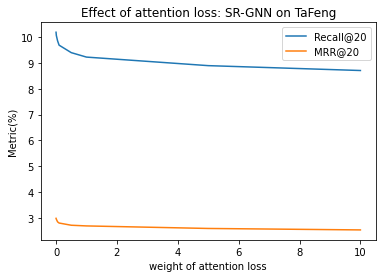

In [ ]:

plt.plot(np.array(weight), np.array(recall),label="Recall@20")
plt.plot(np.array(weight), np.array(mrr),label="MRR@20")
plt.xlabel("weight of attention loss")
plt.ylabel("Metric(%)")
plt.title("Effect of attention loss: SR-GNN on TaFeng")
plt.legend()